# Preprocessing

In [1]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    MT5ForConditionalGeneration,
    T5ForConditionalGeneration,
    RobertaTokenizerFast,
    T5Tokenizer,
    AutoTokenizer,
    AutoModelForTokenClassification,
    T5TokenizerFast,
    T5ForTokenClassification,
    get_linear_schedule_with_warmup
)

torch.cuda.is_available()
# os.chdir('..')

import warnings
warnings.filterwarnings('ignore')

path_save_image = "../figs/"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abuboba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
label2id = {'O': 0, 'B-ALG': 1, 'I-ALG': 2, 'B-APP': 3, 'I-APP': 4, 'B-CB': 5, 'I-CB': 6, 'B-CLA': 7, 'I-CLA': 8, 'B-DEV': 9, 'I-DEV': 10, 'B-DS': 11, 'I-DS': 12, 'B-DT': 13, 'I-DT': 14, 'B-FN': 15, 'I-FN': 16, 'B-FT': 17, 'I-FT': 18, 'B-FUN': 19, 'I-FUN': 20, 'B-HXT': 21, 'I-HXT': 22, 'B-LAN': 23, 'I-LAN': 24, 'B-LIB': 25, 'I-LIB': 26, 'B-OS': 27, 'I-OS': 28, 'B-UIE': 29, 'I-UIE': 30, 'B-UN': 31, 'I-UN': 32, 'B-VAL': 33, 'I-VAL': 34, 'B-VAR': 35, 'I-VAR': 36, 'B-VER': 37, 'I-VER': 38, 'B-WEB': 39, 'I-WEB': 40}
id2label = {label2id[x]: x for x in label2id}
labels = ['Algorithm', 'Application', 'Class', 'Code_Block', 'Data_Structure', 'Data_Type', 'Device', 'File_Name', 'File_Type', 'Function', 'HTML_XML_Tag', 'Language', 'Library', 'Operating_System', 'User_Interface_Element', 'User_Name', 'Value', 'Variable', 'Version', 'Website']
labels_short = ['ALG', 'APP', 'CB', 'CLA', 'DEV', 'DS', 'DT', 'FN', 'FT', 'FUN', 'HXT', 'LAN', 'LIB', 'OS', 'UIE', 'UN', 'VAL', 'VAR', 'VER', 'WEB']
short2long = {'ALG': 'Algorithm', 'APP': 'Application', 'CB': 'Class', 'CLA': 'Code_Block', 'DEV': 'Data_Structure', 'DS': 'Data_Type', 'DT': 'Device', 'FN': 'File_Name', 'FT': 'File_Type', 'FUN': 'Function', 'HXT': 'HTML_XML_Tag', 'LAN': 'Language', 'LIB': 'Library', 'OS': 'Operating_System', 'UIE': 'User_Interface_Element', 'UN': 'User_Name', 'VAL': 'Value', 'VAR': 'Variable', 'VER': 'Version', 'WEB': 'Website'}


In [3]:
import torch
from torch.utils.data import DataLoader
from transformers import T5ForConditionalGeneration, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl

class T5FineTuner(pl.LightningModule):
    def __init__(self, hparam):
        super(T5FineTuner, self).__init__()
        self.hparam = hparam

        self.model = T5ForConditionalGeneration.from_pretrained(
            hparam.model_name_or_path)
        self.tokenizer = AutoTokenizer.from_pretrained(
            hparam.model_name_or_path
        )
        self.save_hyperparameters()

    def is_logger(self):
        return True

    def forward(
        self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None
    ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs.loss

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparam.learning_rate, eps=self.hparam.adam_epsilon)
        t_total = (
            (len(self.train_dataloader().dataset) //
             (self.hparam.train_batch_size * max(1, self.hparam.n_gpu)))
            // self.hparam.gradient_accumulation_steps
            * float(self.hparam.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=self.hparam.warmup_steps, num_training_steps=t_total
        )

        scheduler_config = {
            'scheduler': scheduler,
            'interval': 'step',
            'frequency': 1
        }
        return [optimizer], [scheduler_config]

    def train_dataloader(self):
        train_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="train", args=self.hparam)
        return DataLoader(train_dataset, batch_size=self.hparam.train_batch_size,
                          drop_last=True, shuffle=True, num_workers=2)

    def val_dataloader(self):
        val_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="validation", args=self.hparam)
        return DataLoader(val_dataset, batch_size=self.hparam.eval_batch_size, num_workers=2)


In [4]:
class MyDataset(Dataset):
  def __init__(self, tokenizer, dataset, type_path, max_len=512):

    self.data = dataset[type_path]
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.tokenizer.max_length = max_len
    self.tokenizer.model_max_length = max_len
    self.inputs = []
    self.targets = []

    self._build()

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

  def _build(self):
    for idx in range(len(self.data)):
      input_, target = " ".join(self.data[idx]["tokens"]), "; ".join(self.data[idx]["spans"])

      input_ = input_.lower() + ' </s>'
      target = target.lower() + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target],max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [5]:
from datasets import load_dataset

path = "../data/StackOverflow/json/"

dataset = load_dataset('json', data_files=os.path.join(path, 'data_train.json'))
dataset["test"] = load_dataset('json', data_files=os.path.join(path, 'data_test.json'))["train"]
dataset["validation"] = load_dataset('json', data_files=os.path.join(path, 'data_dev.json'))["train"]
dataset["gh"] = load_dataset('json', data_files=os.path.join("../data/GitHub", 'data_gh.json'))["train"]

In [6]:
model_codet5_t2t = "codet5-small-t2t"
codet5_t2t = T5FineTuner.load_from_checkpoint("../checkpoints/codet5-small-t2t/codet5-small-t2t.ckpt")
tokenizer_codet5_t2t = AutoTokenizer.from_pretrained("Salesforce/codet5-small")

model_t5_t2t = "t5-small-t2t"
t5_t2t = T5FineTuner.load_from_checkpoint("../checkpoints/t5-small-t2t/t5-small-t2t.ckpt")
tokenizer_t5_t2t = AutoTokenizer.from_pretrained("t5-small")

model_codet5_clf = "codet5-small-clf"
tokenizer_codet5_clf = RobertaTokenizerFast.from_pretrained("Salesforce/codet5-small", add_prefix_space=True)
codet5_clf = AutoModelForTokenClassification.from_pretrained(
    "../checkpoints/codet5-small-token-clf/checkpoint-11580", num_labels=len(label2id), id2label=id2label, label2id=label2id, device_map='cuda:0'
)

model_t5_clf = "t5-small-clf"
tokenizer_t5_clf = T5TokenizerFast.from_pretrained("t5-small")
t5_clf = T5ForTokenClassification.from_pretrained(
    "../checkpoints/t5-small-token-clf/checkpoint-11580", num_labels=len(label2id), id2label=id2label, label2id=label2id, device_map='cuda:0'
)

In [7]:
def tokenize_and_align_labels(examples, tokenizer):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
def find_sub_list(sl, l):
    results = []
    sll = len(sl)
    for ind in (i for i, e in enumerate(l) if e == sl[0]):
        if l[ind:ind+sll] == sl:
            results.append((ind, ind+sll-1))
    return results

def generate_label(input: str, target: str):
    mapper = label2id

    inv_mapper = {v: k for k, v in mapper.items()}

    input = input.split(" ")
    target = target.split("; ")

    init_target_label = [mapper['O']]*len(input)

    for ent in target:
        ent = ent.split(": ")
        try:
            sent_end = ent[1].split(" ")
            index = find_sub_list(sent_end, input)
        except:
            continue
        # print(index)
        try:
            init_target_label[index[0][0]] = mapper[f"B-{ent[0].upper()}"]
            for i in range(index[0][0]+1, index[0][1]+1):
                init_target_label[i] = mapper[f"I-{ent[0].upper()}"]
        except:
            continue
    init_target_label = [inv_mapper[j] for j in init_target_label]
    return init_target_label

In [9]:
from tqdm import tqdm

def make_prediction(model, tokenizer, dataset, type_path):
    test_dataset = MyDataset(tokenizer=tokenizer, dataset=dataset, type_path=type_path)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    model.model.eval()
    model = model.to("cuda")
    all_text = []
    true_labels = []
    pred_labels = []
    for batch in tqdm(test_loader):
        input_ids = batch['source_ids'].to("cuda")
        attention_mask = batch['source_mask'].to("cuda")
        outs = model.model.generate(input_ids=input_ids,
                                    attention_mask=attention_mask)
        dec = [tokenizer.decode(ids, skip_special_tokens=True,
                                clean_up_tokenization_spaces=False).strip() for ids in outs]
        target = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                    for ids in batch["target_ids"]]
        texts = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                    for ids in batch["source_ids"]]
        true_label = [generate_label(texts[i].strip(), target[i].strip()) if target[i].strip() != 'none' else [
            "O"]*len(texts[i].strip().split()) for i in range(len(texts))]
        pred_label = [generate_label(texts[i].strip(), dec[i].strip()) if dec[i].strip() != 'none' else [
            "O"]*len(texts[i].strip().split()) for i in range(len(texts))]

        true_labels.extend(true_label)
        pred_labels.extend(pred_label)
        all_text.extend(texts)
    return true_labels, pred_labels, all_text

In [10]:
from datasets import load_metric

metric = load_metric("seqeval")

In [11]:
import evaluate

seqeval = evaluate.load("seqeval")
label_list = list(label2id.keys())

def compute_metrics(p, full=False):
    predictions, labels = p

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    if full:
        return results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn import svm, datasets
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from sklearn.utils.multiclass import unique_labels



# def plot_confusion_matrix(y_true, y_pred, classes,
#                           normalize=False,
#                           title=None,
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = unique_labels(y_true, y_pred)
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     # print(cm)

#     fig, ax = plt.subplots(figsize =(20, 20))
#     im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
#     # We want to show all ticks...
#     ax.set(xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label')

#     # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")

#     # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
#     return ax


# np.set_printoptions(precision=2)

# Results

In [13]:
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer_t5_clf})
tokenized_dataset_code = dataset.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer_codet5_clf})

In [14]:
from tqdm import tqdm

true, pred, _ = make_prediction(t5_t2t, tokenizer_t5_t2t, dataset, "validation")
true_code, pred_code, _ = make_prediction(codet5_t2t, tokenizer_codet5_t2t, dataset, "validation")

t5_t2t_val = metric.compute(predictions=pred, references=true)
codet5_t2t_val = metric.compute(predictions=pred_code, references=true_code)

pred = []
pred_code = []
for item in tqdm(tokenized_dataset["validation"]):
    a = tokenizer_t5_clf(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(t5_clf(**a).logits.cpu().detach(), axis=2)
    pred.extend(predictions)


for item in tqdm(tokenized_dataset_code["validation"]):
    a = tokenizer_codet5_clf(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(codet5_clf(**a).logits.cpu().detach(), axis=2)
    pred_code.extend(predictions)

t5_clf_val = compute_metrics((pred, tokenized_dataset["validation"]["labels"]), True)
codet5_clf_val = compute_metrics((pred_code, tokenized_dataset_code["validation"]["labels"]), True)

#----------------------------------------------------------------------------------------------------------------

true, pred, _ = make_prediction(t5_t2t, tokenizer_t5_t2t, dataset, "test")
true_code, pred_code, _ = make_prediction(codet5_t2t, tokenizer_codet5_t2t, dataset, "test")

t5_t2t_test = metric.compute(predictions=pred, references=true)
codet5_t2t_test = metric.compute(predictions=pred_code, references=true_code)

pred = []
pred_code = []
for item in tqdm(tokenized_dataset["test"]):
    a = tokenizer_t5_clf(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(t5_clf(**a).logits.cpu().detach(), axis=2)
    pred.extend(predictions)


for item in tqdm(tokenized_dataset_code["test"]):
    a = tokenizer_codet5_clf(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(codet5_clf(**a).logits.cpu().detach(), axis=2)
    pred_code.extend(predictions)

t5_clf_test = compute_metrics((pred, tokenized_dataset["test"]["labels"]), True)
codet5_clf_test = compute_metrics((pred_code, tokenized_dataset_code["test"]["labels"]), True)

#----------------------------------------------------------------------------------------------------------------

true, pred, _ = make_prediction(t5_t2t, tokenizer_t5_t2t, dataset, "gh")
true_code, pred_code, _ = make_prediction(codet5_t2t, tokenizer_codet5_t2t, dataset, "gh")

t5_t2t_gh = metric.compute(predictions=pred, references=true)
codet5_t2t_gh = metric.compute(predictions=pred_code, references=true_code)

pred = []
pred_code = []
for item in tqdm(tokenized_dataset["gh"]):
    a = tokenizer_t5_clf(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(t5_clf(**a).logits.cpu().detach(), axis=2)
    pred.extend(predictions)


for item in tqdm(tokenized_dataset_code["gh"]):
    a = tokenizer_codet5_clf(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
    predictions = np.argmax(codet5_clf(**a).logits.cpu().detach(), axis=2)
    pred_code.extend(predictions)

t5_clf_gh = compute_metrics((pred, tokenized_dataset["gh"]["labels"]), True)
codet5_clf_gh = compute_metrics((pred_code, tokenized_dataset_code["gh"]["labels"]), True)


# t5_t2t_test
# codet5_t2t_test
# t5_clf_test
# codet5_clf_test

# t5_t2t_val
# codet5_t2t_val
# t5_clf_val
# codet5_clf_val

# t5_t2t_gh
# codet5_t2t_gh
# t5_clf_gh
# codet5_clf_gh

100%|██████████| 8023/8023 [00:43<00:00, 184.47it/s]


## Validation set

In [15]:
size_ovv, size_each, title = 20, 32, 0.93
size_sqr, size_title = 10, 20
size_f1 = 20

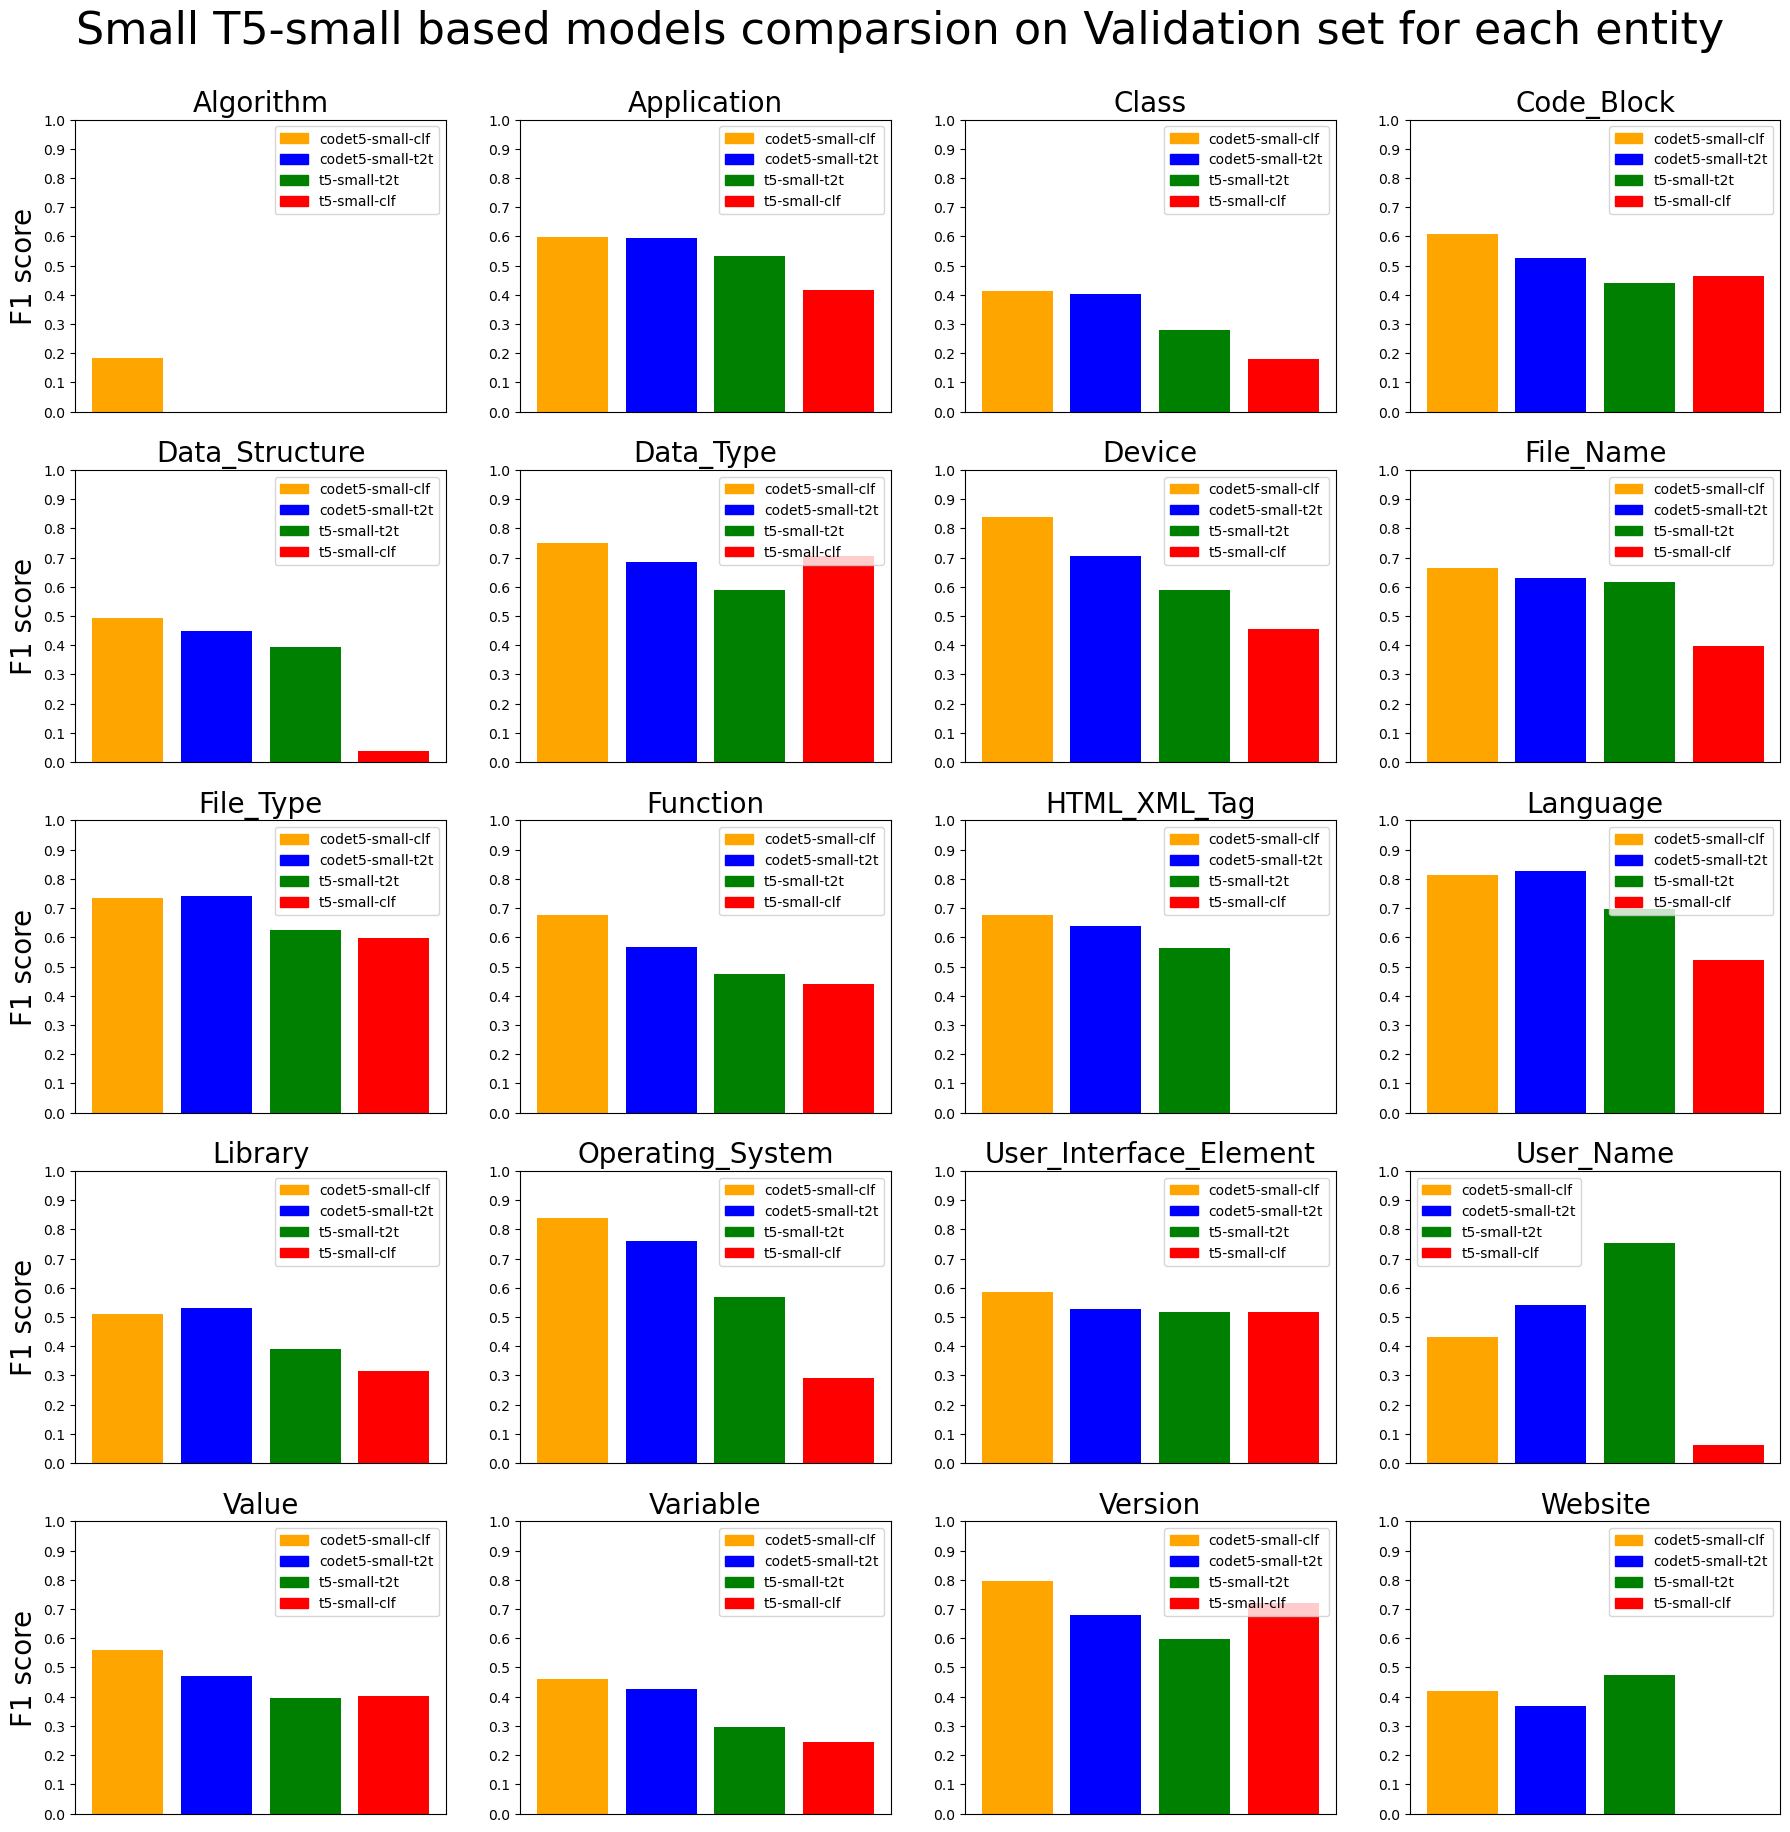

In [16]:
from matplotlib import pyplot as plt

dct_t5_t2t = {x: t5_t2t_val[x]["f1"] for x in t5_t2t_val if "overall" not in x}
dct_t5_clf = {x: t5_clf_val[x]["f1"] for x in t5_clf_val if "overall" not in x}
dct_codet5_t2t = {x: codet5_t2t_val[x]["f1"] for x in codet5_t2t_val if "overall" not in x}
dct_codet5_clf = {x: codet5_clf_val[x]["f1"] for x in codet5_clf_val if "overall" not in x}


data = {
    model_codet5_clf: list(dct_codet5_clf.values()),
    model_codet5_t2t: list(dct_codet5_t2t.values()),
    model_t5_t2t: list(dct_t5_t2t.values()),
    model_t5_clf: list(dct_t5_clf.values()),
}
length = len(list(dct_t5_t2t.values()))
X = [short2long[x] for x in dct_t5_t2t.keys()]
colors = ['orange', 'blue', 'green', 'red']

fig, axes = plt.subplots(5, 4, figsize =(22, 22))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    if i % 4 == 0:
        ax[i].set_ylabel('F1 score', fontsize = size_f1) 
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)


plt.suptitle("Small T5-small based models comparsion on Validation set for each entity", fontsize=size_each, y=title)
plt.savefig(path_save_image + 'plot_t5-small_val.png', bbox_inches='tight')
plt.show()

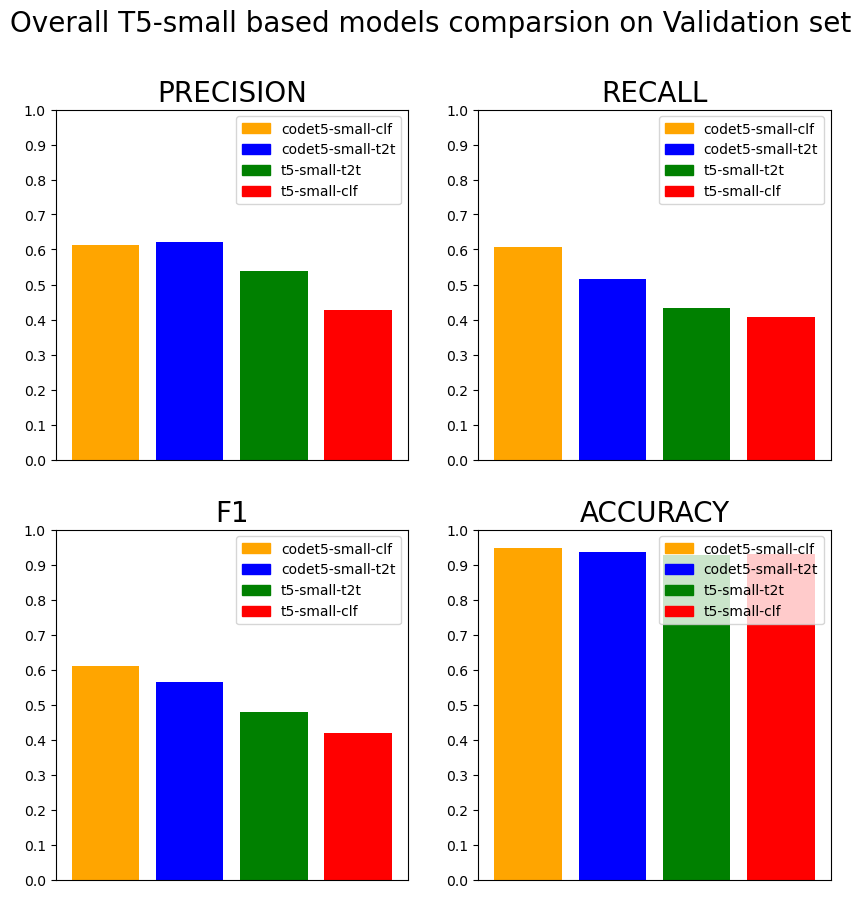

In [17]:
dct_t5_t2t = {x: t5_t2t_val[x] for x in t5_t2t_val if "overall"  in x}
dct_t5_clf = {x: t5_clf_val[x] for x in t5_clf_val if "overall"  in x}
dct_codet5_t2t = {x: codet5_t2t_val[x] for x in codet5_t2t_val if "overall"  in x}
dct_codet5_clf = {x: codet5_clf_val[x] for x in codet5_clf_val if "overall"  in x}

data = {
    model_codet5_clf: list(dct_codet5_clf.values()),
    model_codet5_t2t: list(dct_codet5_t2t.values()),
    model_t5_t2t: list(dct_t5_t2t.values()),
    model_t5_clf: list(dct_t5_clf.values()),
}
length = len(list(dct_t5_t2t.values()))
X = [x.split("_")[1].upper() for x in dct_t5_t2t.keys() if "overall" in x]
colors = ['orange', 'blue', 'green', 'red']


fig, axes = plt.subplots(2, 2, figsize =(10, 10))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)

plt.suptitle('Overall T5-small based models comparsion on Validation set', fontsize=size_ovv)
plt.savefig(path_save_image + 'plot_t5-small_val_over.png', bbox_inches='tight')
plt.show()

In [18]:
text = \
f"""
F1 scores on VALIDATION set:\n
{model_codet5_clf} - {dct_codet5_clf['overall_f1']}
{model_codet5_t2t} - {dct_codet5_t2t['overall_f1']}
{model_t5_t2t} - {dct_t5_t2t['overall_f1']}
{model_t5_clf} - {dct_t5_clf['overall_f1']}
"""

print(text)


F1 scores on VALIDATION set:

codet5-small-clf - 0.6097161572052402
codet5-small-t2t - 0.5643440050219711
t5-small-t2t - 0.4799618320610687
t5-small-clf - 0.4178938594053903



In [19]:
# conf_true_val = []
# for x in true_code:
#     conf_true_val.extend(x)

# conf_pred_val = []
# for x in pred_code:
#     conf_pred_val.extend(x)

# plot_confusion_matrix(conf_true_val, conf_pred_val, classes=None,
#                       title='Confusion matrix for Test set')
# plt.show()

## Test set

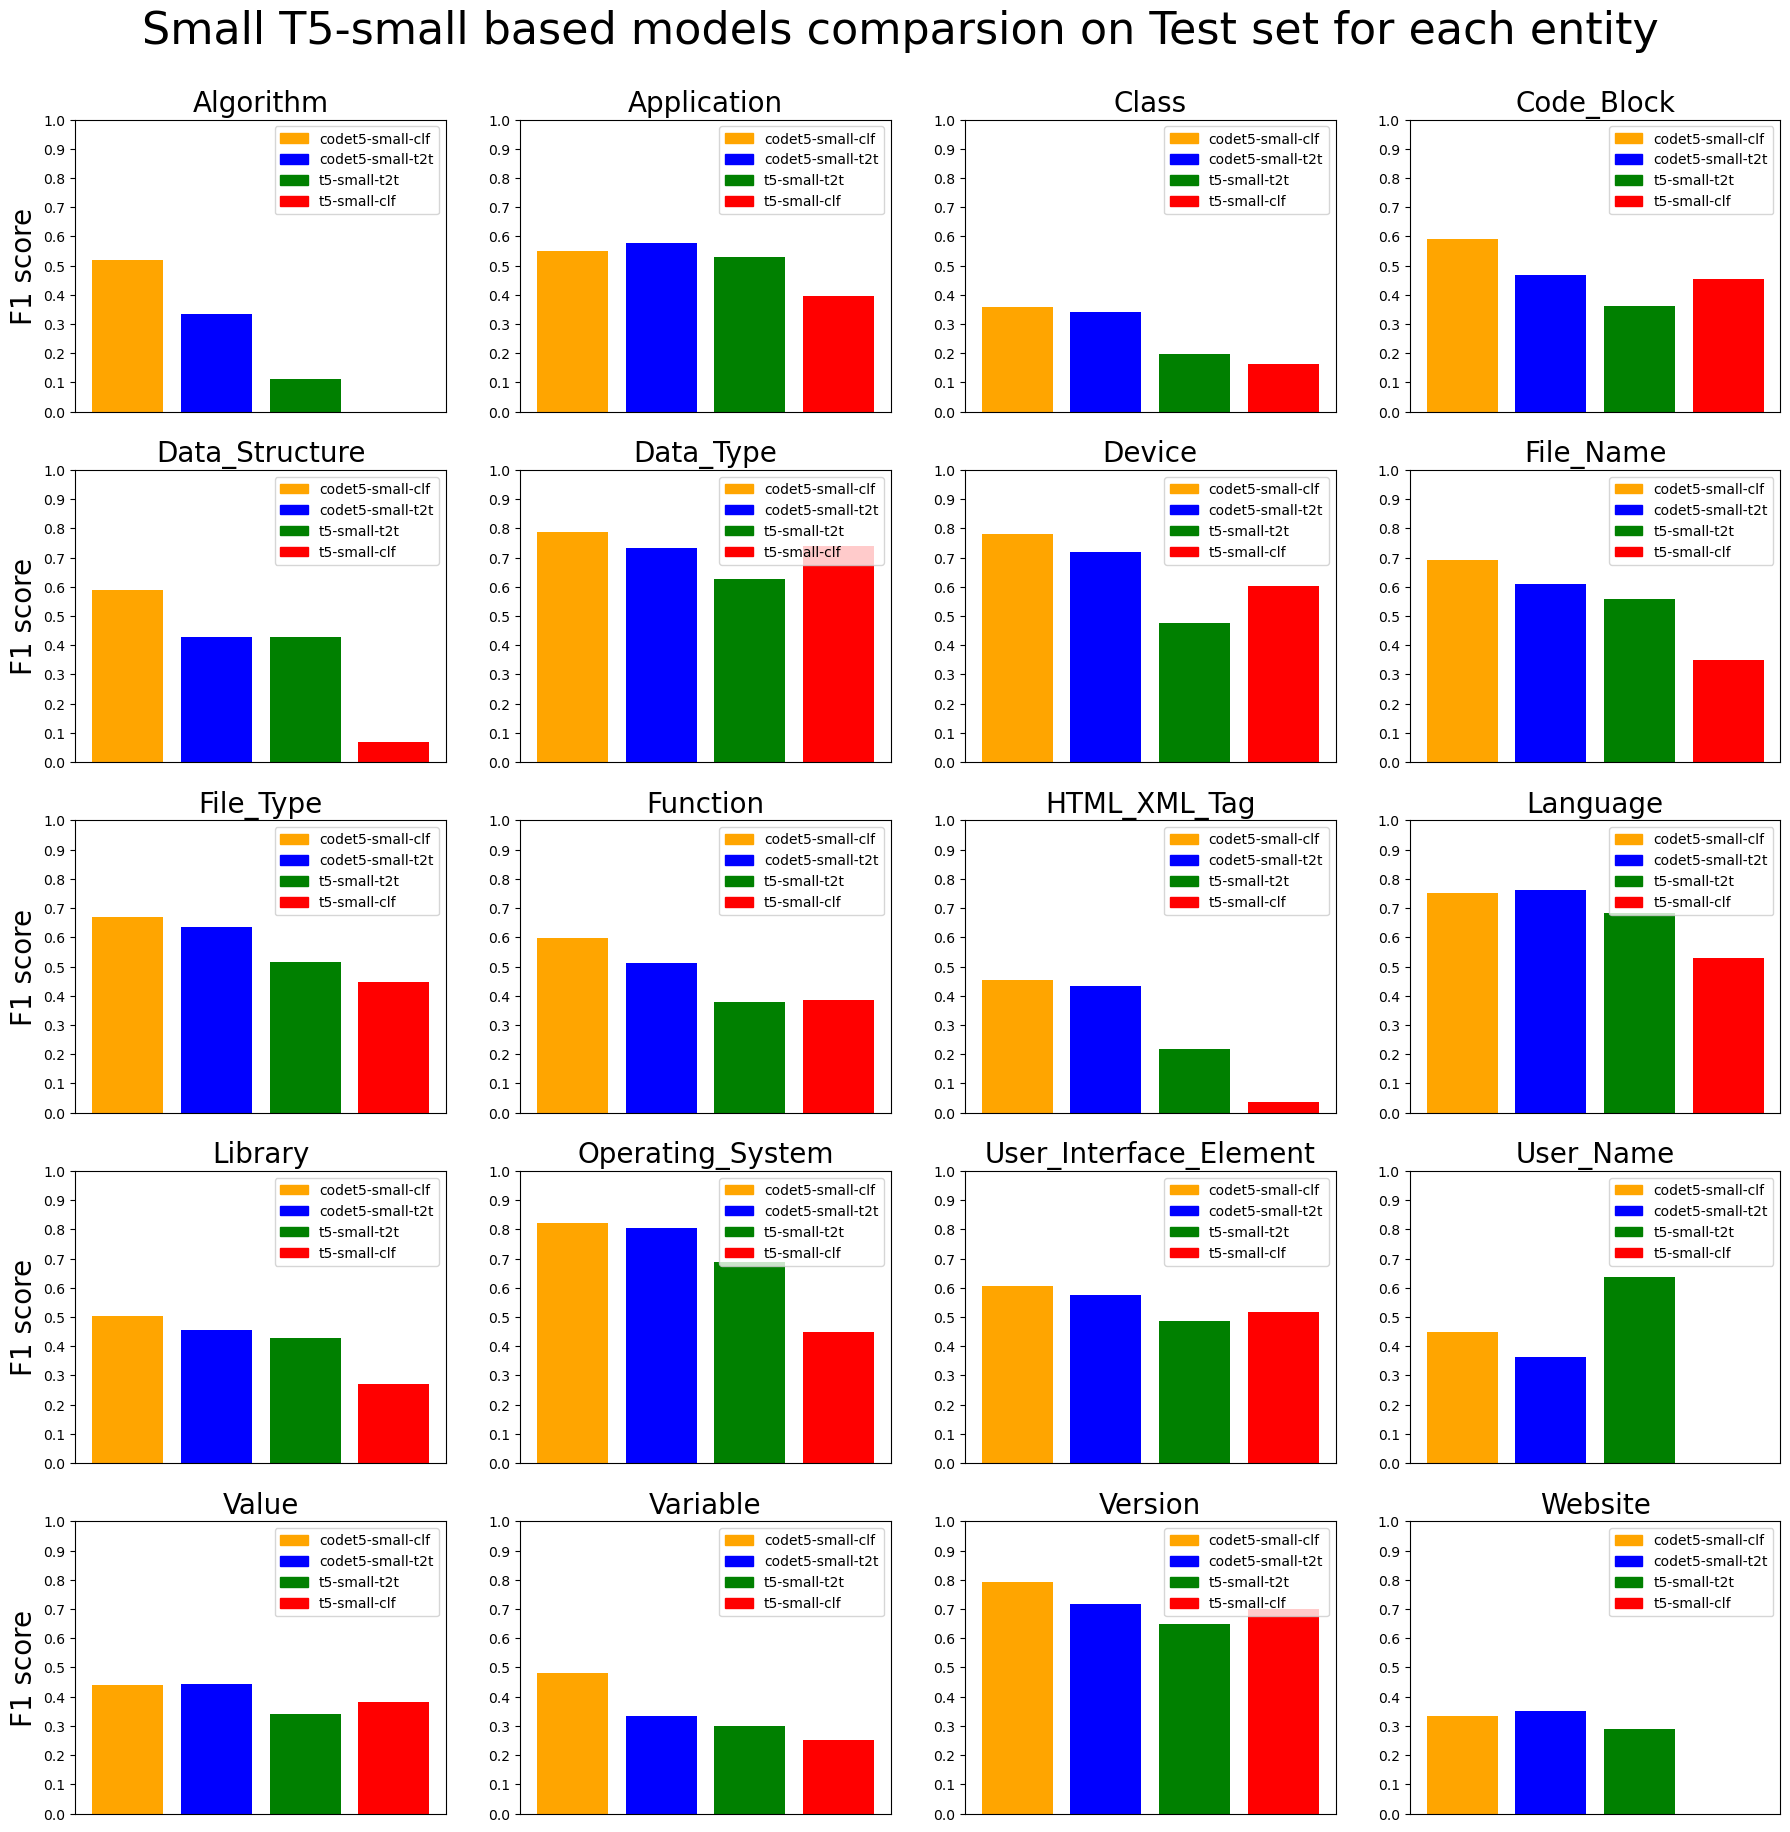

In [20]:
from matplotlib import pyplot as plt

dct_t5_t2t = {x: t5_t2t_test[x]["f1"] for x in t5_t2t_test if "overall" not in x}
dct_t5_clf = {x: t5_clf_test[x]["f1"] for x in t5_clf_test if "overall" not in x}
dct_codet5_t2t = {x: codet5_t2t_test[x]["f1"] for x in codet5_t2t_test if "overall" not in x}
dct_codet5_clf = {x: codet5_clf_test[x]["f1"] for x in codet5_clf_test if "overall" not in x}


data = {
    model_codet5_clf: list(dct_codet5_clf.values()),
    model_codet5_t2t: list(dct_codet5_t2t.values()),
    model_t5_t2t: list(dct_t5_t2t.values()),
    model_t5_clf: list(dct_t5_clf.values()),
}
length = len(list(dct_t5_t2t.values()))
X = [short2long[x] for x in dct_t5_t2t.keys()]
colors = ['orange', 'blue', 'green', 'red']

fig, axes = plt.subplots(5, 4, figsize =(22, 22))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    if i % 4 == 0:
        ax[i].set_ylabel('F1 score', fontsize = size_f1) 
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)


plt.suptitle("Small T5-small based models comparsion on Test set for each entity", fontsize=size_each, y=title)
plt.savefig(path_save_image + 'plot_t5-small_test.png', bbox_inches='tight')
plt.show()

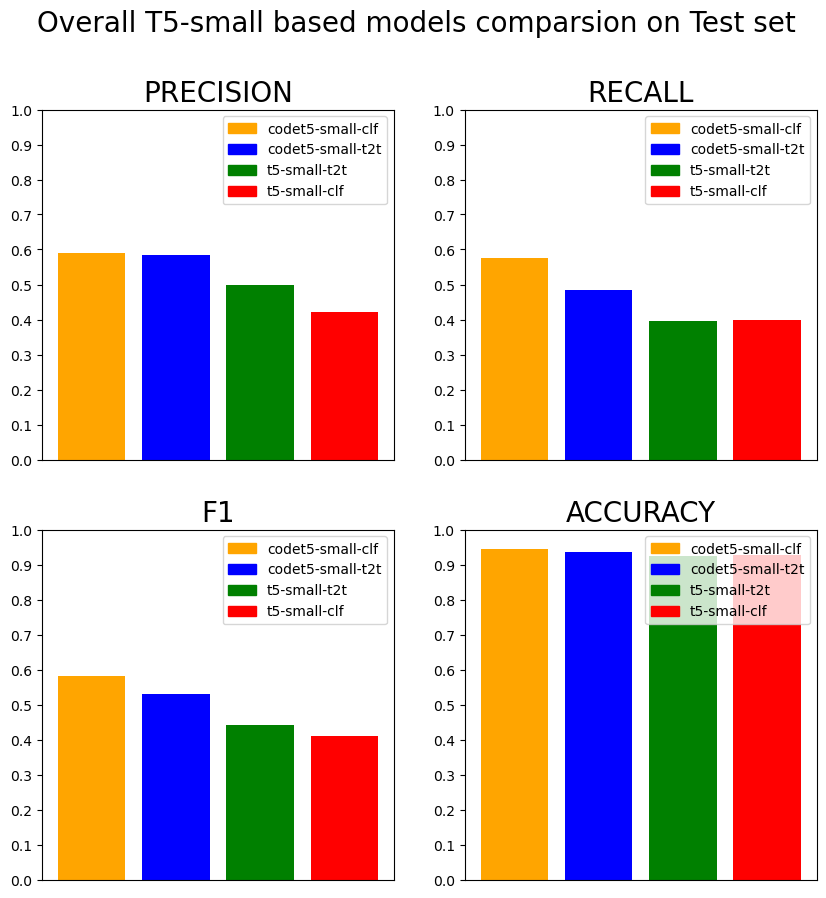

In [21]:
dct_t5_t2t = {x: t5_t2t_test[x] for x in t5_t2t_test if "overall"  in x}
dct_t5_clf = {x: t5_clf_test[x] for x in t5_clf_test if "overall"  in x}
dct_codet5_t2t = {x: codet5_t2t_test[x] for x in codet5_t2t_test if "overall"  in x}
dct_codet5_clf = {x: codet5_clf_test[x] for x in codet5_clf_test if "overall"  in x}

data = {
    model_codet5_clf: list(dct_codet5_clf.values()),
    model_codet5_t2t: list(dct_codet5_t2t.values()),
    model_t5_t2t: list(dct_t5_t2t.values()),
    model_t5_clf: list(dct_t5_clf.values()),
}
length = len(list(dct_t5_t2t.values()))
X = [x.split("_")[1].upper() for x in dct_t5_t2t.keys() if "overall" in x]
colors = ['orange', 'blue', 'green', 'red']


fig, axes = plt.subplots(2, 2, figsize =(10, 10))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)

plt.suptitle('Overall T5-small based models comparsion on Test set', fontsize=size_ovv)
plt.savefig(path_save_image + 'plot_t5-small_test_over.png', bbox_inches='tight')
plt.show()

In [22]:
text = \
f"""
F1 scores on TEST set:\n
{model_codet5_clf} - {dct_codet5_clf['overall_f1']}
{model_codet5_t2t} - {dct_codet5_t2t['overall_f1']}
{model_t5_t2t} - {dct_t5_t2t['overall_f1']}
{model_t5_clf} - {dct_t5_clf['overall_f1']}
"""

print(text)


F1 scores on TEST set:

codet5-small-clf - 0.5827018552390907
codet5-small-t2t - 0.530745295599348
t5-small-t2t - 0.4413188142770719
t5-small-clf - 0.41054165011256794



# Domain adaptation

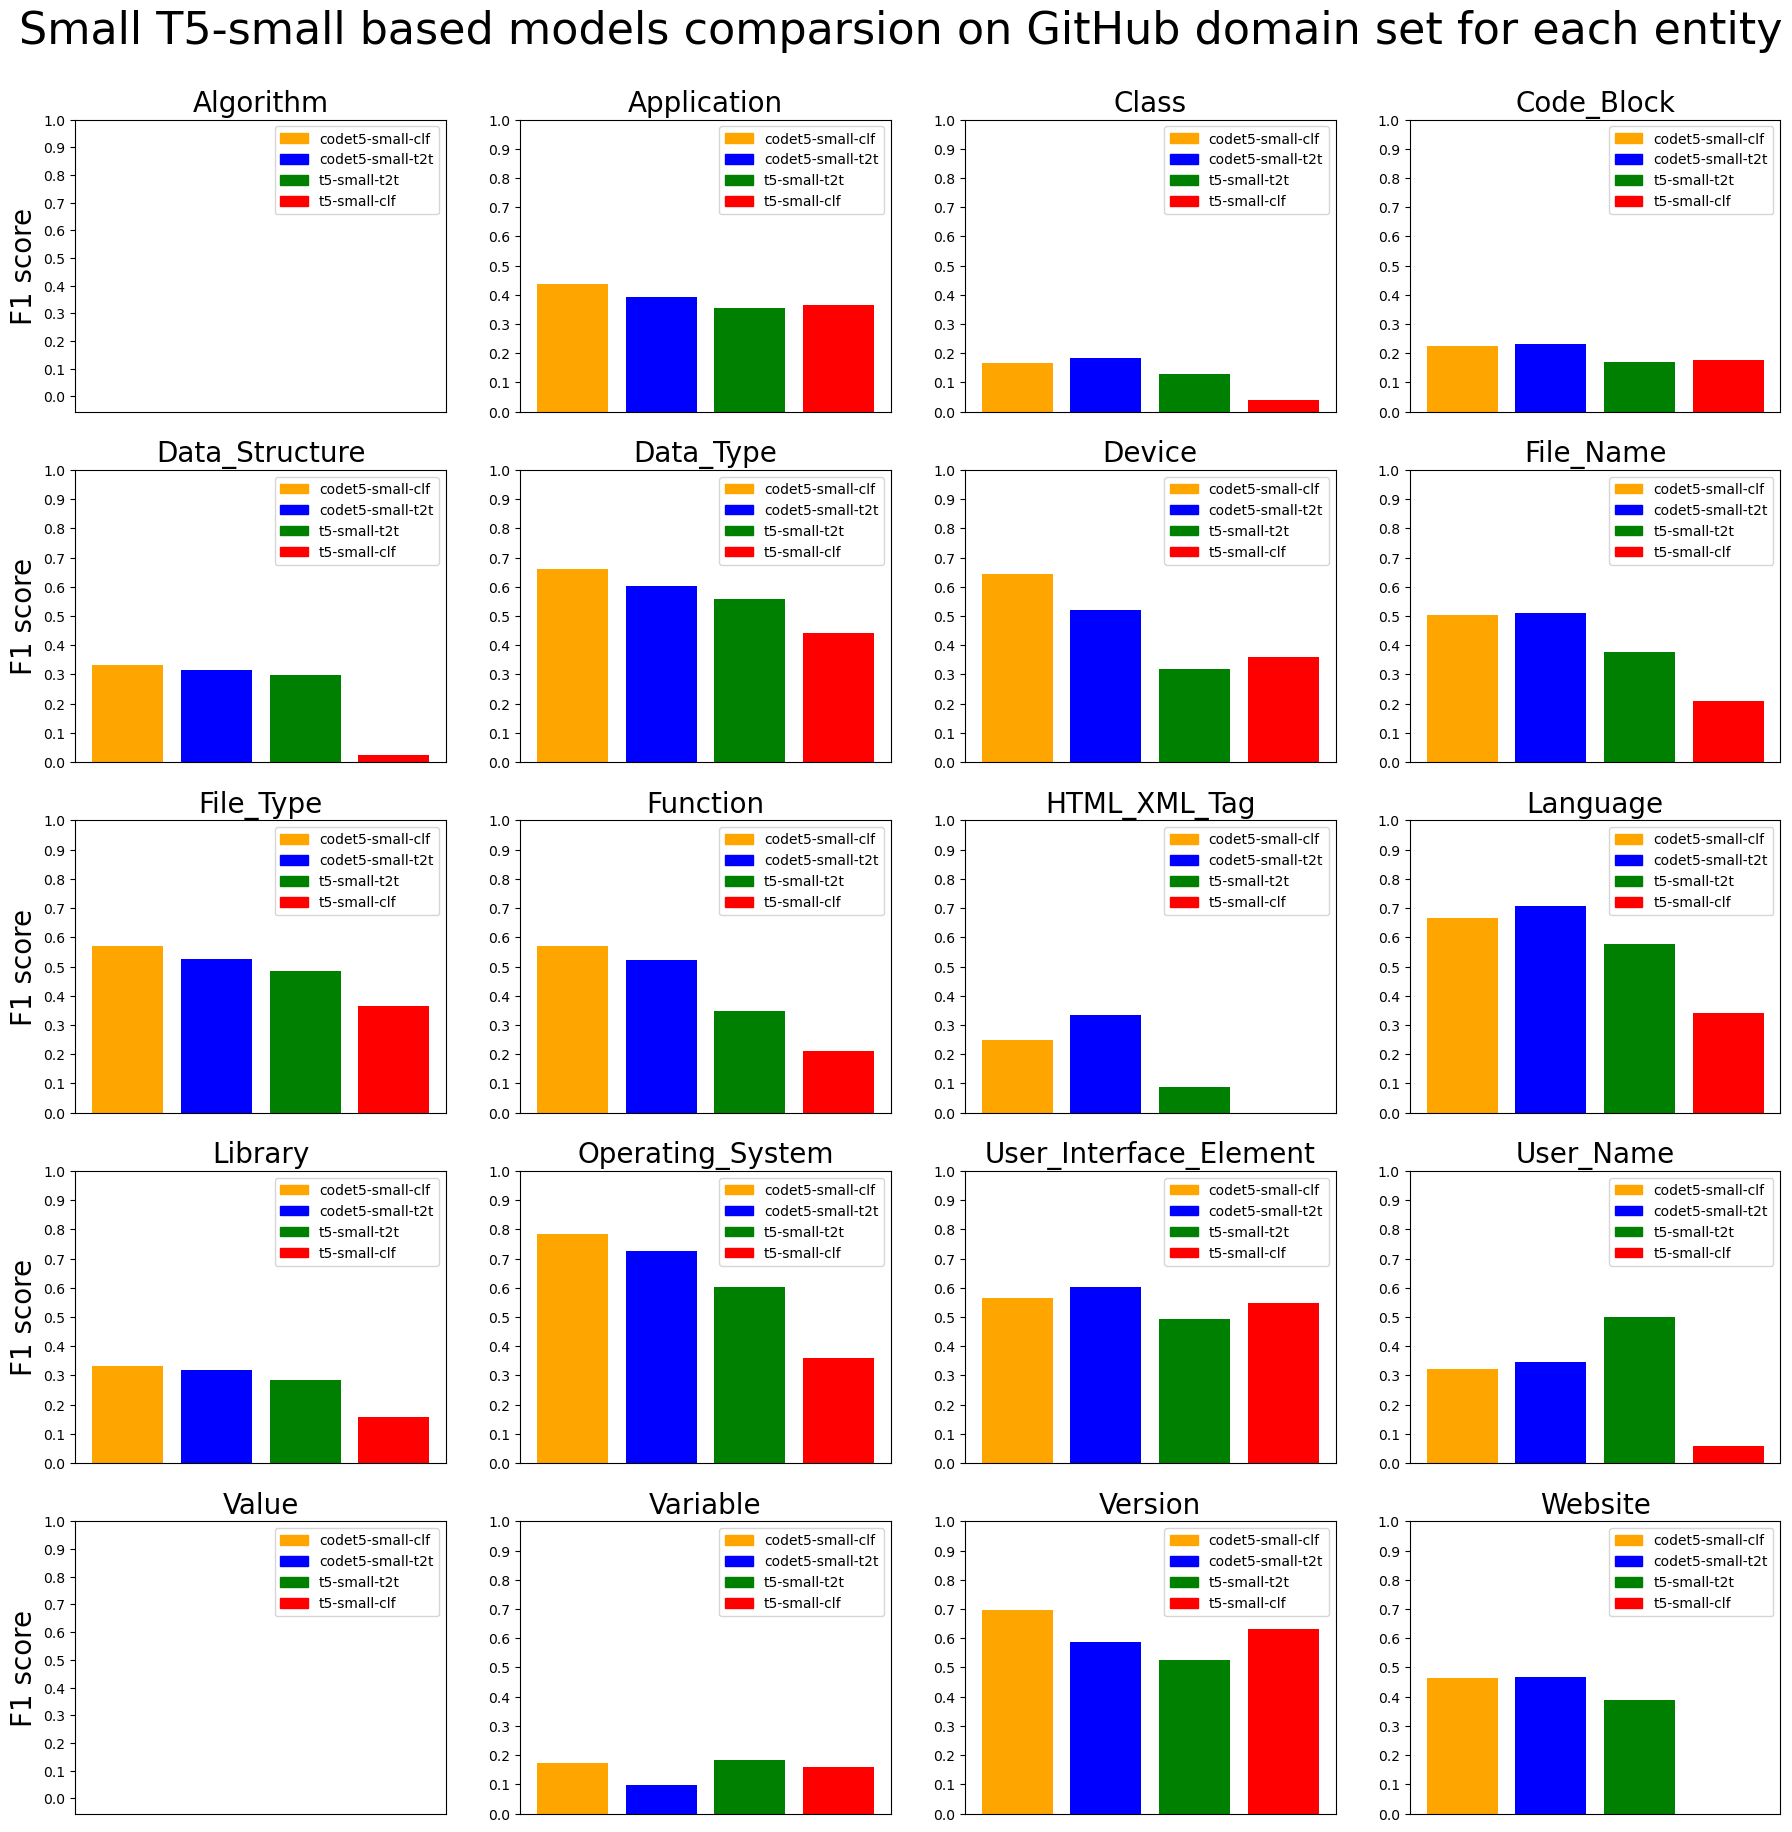

In [23]:
from matplotlib import pyplot as plt

dct_t5_t2t = {x: t5_t2t_gh[x]["f1"] for x in t5_t2t_gh if "overall" not in x}
dct_t5_clf = {x: t5_clf_gh[x]["f1"] for x in t5_clf_gh if "overall" not in x}
dct_codet5_t2t = {x: codet5_t2t_gh[x]["f1"] for x in codet5_t2t_gh if "overall" not in x}
dct_codet5_clf = {x: codet5_clf_gh[x]["f1"] for x in codet5_clf_gh if "overall" not in x}


data = {
    model_codet5_clf: list(dct_codet5_clf.values()),
    model_codet5_t2t: list(dct_codet5_t2t.values()),
    model_t5_t2t: list(dct_t5_t2t.values()),
    model_t5_clf: list(dct_t5_clf.values()),
}
length = len(list(dct_t5_t2t.values()))
X = [short2long[x] for x in dct_t5_t2t.keys()]
colors = ['orange', 'blue', 'green', 'red']

fig, axes = plt.subplots(5, 4, figsize =(22, 22))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    if i % 4 == 0:
        ax[i].set_ylabel('F1 score', fontsize = size_f1) 
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)


plt.suptitle("Small T5-small based models comparsion on GitHub domain set for each entity", fontsize=size_each, y=title)
plt.savefig(path_save_image + 'plot_t5-small_gh.png', bbox_inches='tight')
plt.show()

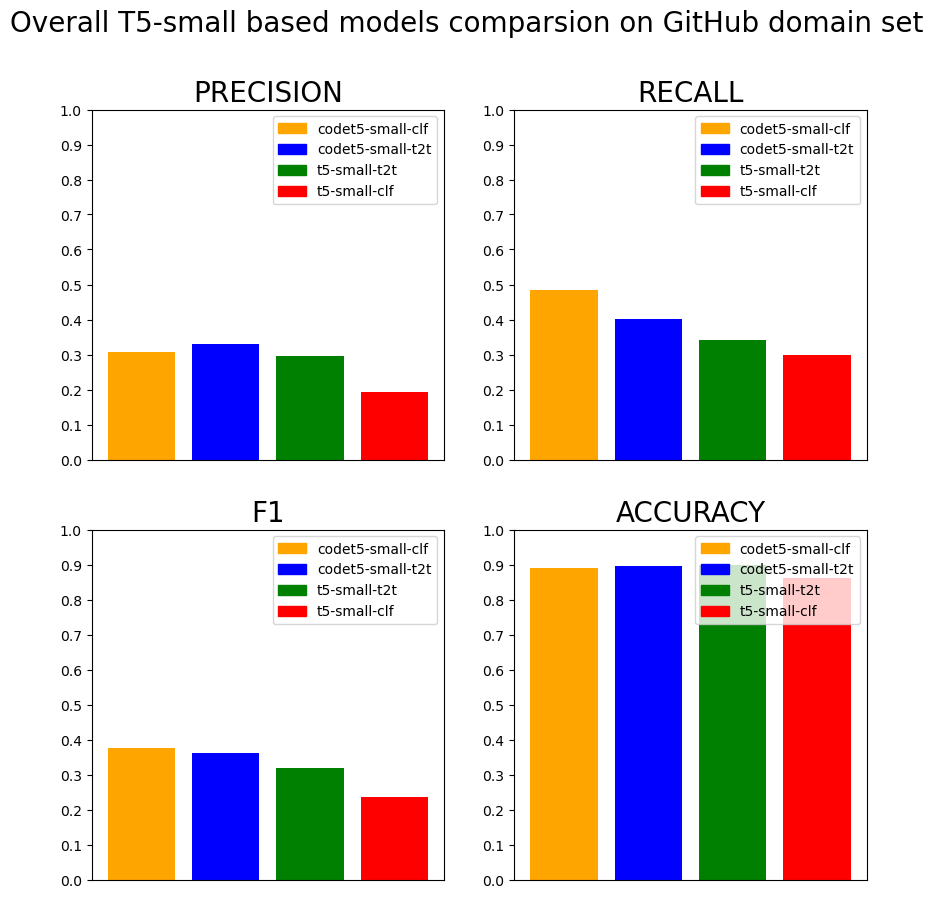

In [24]:
dct_t5_t2t = {x: t5_t2t_gh[x] for x in t5_t2t_gh if "overall"  in x}
dct_t5_clf = {x: t5_clf_gh[x] for x in t5_clf_gh if "overall"  in x}
dct_codet5_t2t = {x: codet5_t2t_gh[x] for x in codet5_t2t_gh if "overall"  in x}
dct_codet5_clf = {x: codet5_clf_gh[x] for x in codet5_clf_gh if "overall"  in x}

data = {
    model_codet5_clf: list(dct_codet5_clf.values()),
    model_codet5_t2t: list(dct_codet5_t2t.values()),
    model_t5_t2t: list(dct_t5_t2t.values()),
    model_t5_clf: list(dct_t5_clf.values()),
}
length = len(list(dct_t5_t2t.values()))
X = [x.split("_")[1].upper() for x in dct_t5_t2t.keys() if "overall" in x]
colors = ['orange', 'blue', 'green', 'red']


fig, axes = plt.subplots(2, 2, figsize =(10, 10))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)

plt.suptitle('Overall T5-small based models comparsion on GitHub domain set', fontsize=size_ovv)
plt.savefig(path_save_image + 'plot_t5-small_gh_over.png', bbox_inches='tight')
plt.show()

In [25]:
text = \
f"""
F1 scores on GITHUB DOMAIN set:\n
{model_codet5_clf} - {dct_codet5_clf['overall_f1']}
{model_codet5_t2t} - {dct_codet5_t2t['overall_f1']}
{model_t5_t2t} - {dct_t5_t2t['overall_f1']}
{model_t5_clf} - {dct_t5_clf['overall_f1']}
"""

print(text)


F1 scores on GITHUB DOMAIN set:

codet5-small-clf - 0.37597949469058956
codet5-small-t2t - 0.36247561624401486
t5-small-t2t - 0.317882008061561
t5-small-clf - 0.2355298308103295

